In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

---
K-NN Classifying the Iris Dataset, Receiver Operator Characteristic
=====
***

In [2]:
iris = datasets.load_iris()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size = 0.5, random_state=17)

In [4]:
min_score = 1.0e99

#optimize for k
for k in xrange(1, 30):
    clf = KNeighborsClassifier(k)
    clf.fit(X_train, y_train)
    the_score = clf.score(X_test, y_test)
    if the_score < min_score:
        min_score = the_score
        min_clf = clf
        min_k = k

print "Minimum using k = {:d}".format(min_k)
print min_score

Minimum using k = 28
0.853333333333


###serotosa = 0, versicolor = 1, virginica = 2

In [5]:
def my_confusion_matrix(y_test, y_hat, names):
    '''This function uses the pd.crosstab function to create a confusion matrix:
    predictions are the predictions from the predictive mode
    y are the known class labels
    names are the names of the features used in the model'''
    
    cf = pd.crosstab(y_test, y_hat)
    cf.columns = names
    cf.index = names
    cf.columns.name = 'Prediction'
    cf.index.name = 'Actual'
    return cf

In [6]:
y_hat = min_clf.predict(X_test)

In [7]:
cm = my_confusion_matrix(y_test, y_hat, iris.target_names)
cm

Prediction,setosa,versicolor,virginica
Actual,,,
setosa,23,0,0
versicolor,1,25,3
virginica,0,7,16


In [8]:
print "Accuracy {:5.2f}".format(clf.score(X_test, y_test))

Accuracy  0.89


In [9]:
print classification_report(y_test, y_hat, target_names = iris.target_names)

             precision    recall  f1-score   support

     setosa       0.96      1.00      0.98        23
 versicolor       0.78      0.86      0.82        29
  virginica       0.84      0.70      0.76        23

avg / total       0.85      0.85      0.85        75



In [10]:
sk_cm = confusion_matrix(y_test, y_hat)
print sk_cm

[[23  0  0]
 [ 1 25  3]
 [ 0  7 16]]


new X shape is  (150, 84)
0.586666666667
             precision    recall  f1-score   support

          0       0.85      0.96      0.90        23
          1       0.58      0.24      0.34        29
          2       0.58      0.65      0.61        23

avg / total       0.66      0.59      0.60        75

[ 2.   1.   0.8  0.6  0.4  0.2  0. ]


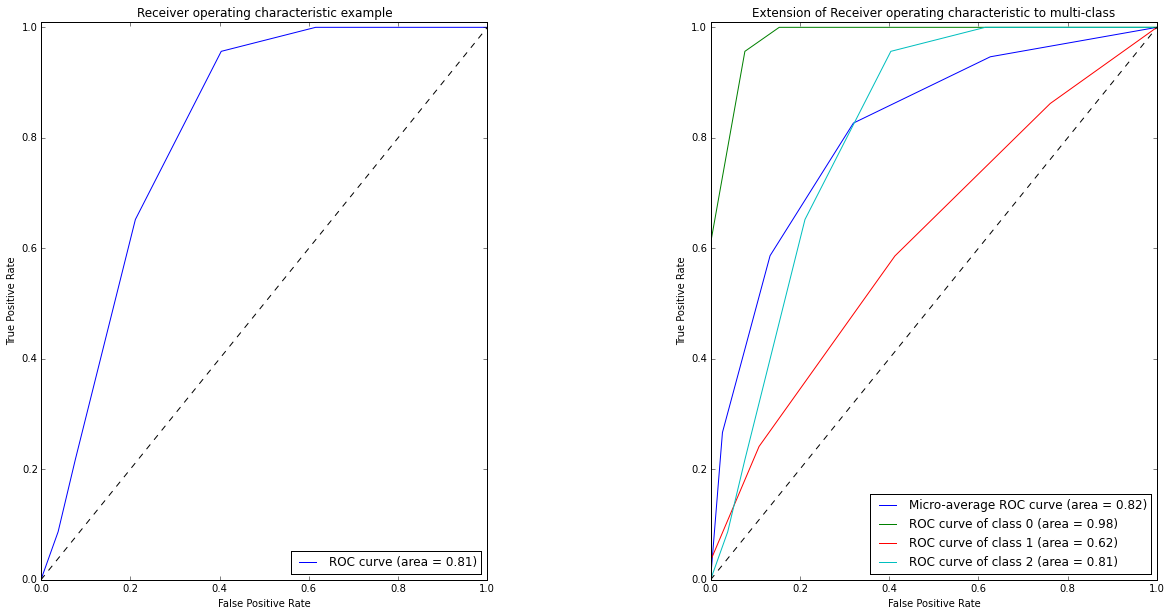

In [22]:
#Restart from fresh
X=iris.data
y=iris.target

#This converts the labels, which are 0, 1, and 2, for the 3 classes into binary labels to represent the 3 classes, 001, 010, 100...
bin_y = label_binarize(y, classes=[0,1,2])
n_classes = 3

#Add some noise to the data to make the problem a little harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 20 * n_features)]
print "new X shape is ", X.shape

#Do a train test split
X_train, X_test, y_train, y_test = train_test_split(X, bin_y, test_size = 0.5, random_state=17)

#Use the one vs rest classifier helper function
clf = OneVsRestClassifier(KNeighborsClassifier(5))

#fit the model
clf.fit(X_train, y_train)

#print the accuracy
print clf.score(X_test, y_test)

#print the classification report
print classification_report(y_test, clf.predict(X_test))

#need the probabilities for the roc
y_probs = clf.predict_proba(X_test)

#define 3 dictionaries = false positive rate, true positive rate and roc_auc
#use a dictionary because we have a multi-class problem
fpr = dict()
tpr = dict()
roc_auc = dict()
thresholds = dict()

for i in range(n_classes):
    #nb: roc_curve is binary only! It returns increasing false and true positive rates
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i], y_probs[:, i])
    
    #auc just calculates the area under the curve, as given by the fp and tp rates
    roc_auc[i] = auc(fpr[i], tpr[i])
    
#"micro" refers to this being a globally averaged estimate
#because we have binarized the labels we can use the roc_curve function
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
   
fig = plt.figure(figsize = (20, 10))    
    
# Plot of a ROC curve for a specific class
ax = plt.subplot(121)   
the_class = 2

ax.plot(fpr[the_class], tpr[the_class], label='ROC curve (area = {:0.2f})'.format(roc_auc[the_class]))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.01])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")    
    
# Plot ROC curve multiclass
ax = plt.subplot(122)
ax.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.01])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Extension of Receiver operating characteristic to multi-class')
ax.legend(loc="lower right")

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)